uploaded all data files in ondrive and continue training on Google Colab due to lack of gpu
-had to change the paths.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
#Importing all libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [4]:
# Setup Paths
POS_PATH = os.path.join('/content/drive/MyDrive/siameese/data','/content/drive/MyDrive/siameese/data/anchor')
NEG_PATH = os.path.join('/content/drive/MyDrive/siameese/data','/content/drive/MyDrive/siameese/data/negative2')
ANC_PATH = os.path.join('/content/drive/MyDrive/siameese/data', '/content/drive/MyDrive/siameese/data/positive')
VER_PATH = os.path.join('/content/drive/MyDrive/siameese/application_data', '/content/drive/MyDrive/siameese/application_data/verification_images')
INP_PATH = os.path.join('/content/drive/MyDrive/siameese/application_data', '/content/drive/MyDrive/siameese/application_data/input_image')

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(580)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(580)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(580)

In [8]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105,105))
    img = img / 255.0
    return img

In [10]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


In [11]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [12]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [13]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16, drop_remainder =True)
test_data = test_data.prefetch(8)

In [14]:
def make_embedding():
    inp = Input(shape=(105,105,3), name='input_image')

    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [15]:
embedding = make_embedding()

In [16]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [17]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [18]:
def make_siamese_model():

    # Handle inputs
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validaption_img', shape=(105,105,3))


    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='siamese_network')

In [19]:
siamese_model = make_siamese_model()

In [20]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(0.0001)

In [21]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [22]:
@tf.function
def train_step(batch):

    # Record all operations
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [23]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2], verbose=0)
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [24]:
EPOCHS = 20

In [25]:
train(train_data, EPOCHS)


 Epoch 1/20
51/51 [==============================] - 242s 364ms/step
0.33480522 0.5301205 0.88709676

 Epoch 2/20
51/51 [==============================] - 16s 324ms/step
0.31472635 0.83762884 0.9587021

 Epoch 3/20
51/51 [==============================] - 17s 328ms/step
0.21206002 0.8861386 0.9781421

 Epoch 4/20
51/51 [==============================] - 17s 335ms/step
0.18067916 0.9282178 0.984252

 Epoch 5/20
51/51 [==============================] - 16s 322ms/step
0.24540949 0.92195123 0.97172236

 Epoch 6/20
51/51 [==============================] - 17s 329ms/step
0.044288818 0.95760596 0.9846154

 Epoch 7/20
51/51 [==============================] - 17s 329ms/step
0.32630688 0.9401496 0.9817708

 Epoch 8/20
51/51 [==============================] - 17s 328ms/step
0.08683103 0.95555556 0.9897698

 Epoch 9/20
51/51 [==============================] - 17s 327ms/step
0.12041372 0.9513382 0.99491096

 Epoch 10/20
51/51 [==============================] - 17s 336ms/step
0.15742323 0.91133004 

In [27]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val], verbose=0)
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

0.9580838 1.0


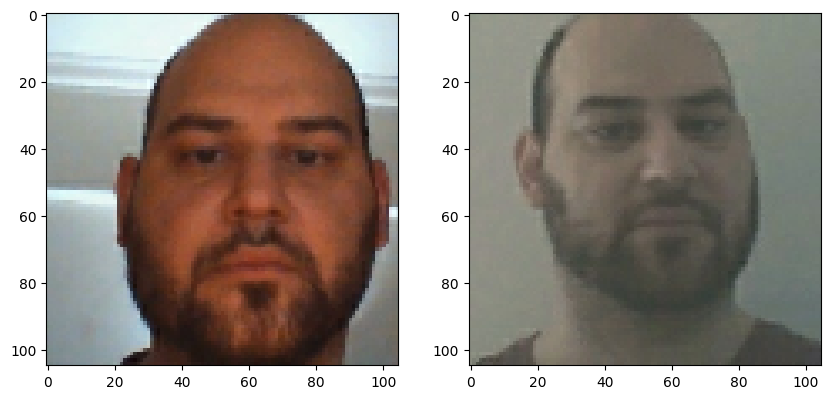

1.0


In [31]:

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[8])
plt.subplot(1,2,2)
plt.imshow(test_val[8])
plt.show()
print(y_true[8])

In [32]:
siamese_model.save('/content/drive/MyDrive/siameese/siamesemodel_v2.h5')

In [33]:
model = tf.keras.models.load_model('/content/drive/MyDrive/siameese/siamesemodel_v2.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [34]:
model.predict([test_input, test_val])

1/1 [==============================] - 0s 206ms/step


array([[9.9998605e-01],
       [7.8988123e-01],
       [9.9853539e-01],
       [1.3527639e-07],
       [1.5894433e-04],
       [2.9776963e-08],
       [1.7897035e-05],
       [1.7857965e-07],
       [9.9999905e-01],
       [9.9990404e-01],
       [6.1096266e-08],
       [8.7258881e-01],
       [9.8986650e-01],
       [8.8383532e-01],
       [1.3483475e-07],
       [9.4568031e-06]], dtype=float32)

In [35]:
model.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validaption_img (InputLayer)   [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validaption_img[0

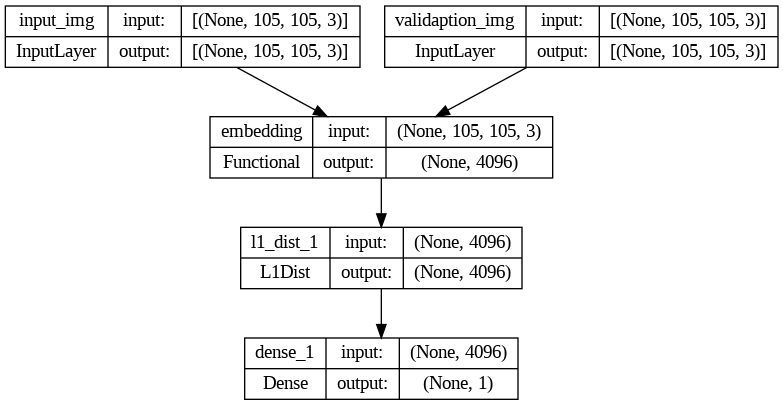

In [38]:
# Plot the model structure
plot_model(model, show_shapes=True)

downloaded the model and continue the veryfication on the local environment.
